# 1083 Albumin Initial ML

### By: Ian Weimer

## Imports

In [280]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
from imblearn.over_sampling import SMOTE, SMOTENC
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [281]:
df = pd.read_csv('C:/Users/Iweimer/Desktop/BB_Git/1083-albumin-data-exploration/ML/GI_Bleed_Tables/blood_diseases_matched_alb_24h_full.csv')

In [282]:
# drop insignificant vars

#df.drop(columns = ['bed_size', 'Cirrhosis', 'tenant'], inplace=True)

In [283]:
df.head()

encounterid  ICU  mass_transfusion  \
0  83aedaea-94b0-405c-a1ea-94fee7f50b52    1                 0   
1  b08d47a1-2a9e-4b7a-b008-f71641dcb93a    0                 0   
2  a3756a81-c2d1-41bd-831d-cc65e73299c6    1                 1   
3  d58ab90d-6928-4e32-af06-c3479e437faa    0                 0   
4  008fb547-53e0-467e-92b2-590982e390b8    1                 0   

   total_transfusions  anemia_status  CCI  bl_albumin_value  qSOFA  Cirrhosis  \
0                   0            0.0    4               3.5      1          0   
1                   0            0.0    2               3.9      0          0   
2                   0            0.0    1               3.5      1          0   
3                   0            2.0    4               2.2      0          1   
4                   1            2.0    6               3.3      1          0   

   beta_blocker  hemorrhagic  SAPS  propensity_score  propensity_logit  \
0             1            0    34          0.492114         -0.031547   
1             1            0    41          0.296393         -0.864535   
2             0            0    29          0.615716          0.471403   
3             1            1    31          0.784942          1.294700   
4             1            1    20          0.509232          0.036933   

   albumin_24hrs                              personid   LOS_hours  \
0              1  1df390c3-18b8-41b0-acd9-23495059e97a  343.133333   
1              1  1f7e4dd3-9985-4039-8099-ecea6ec7b94d  333.866667   
2              1  3cc07cf0-d9b1-486a-a33f-7a0db69304dd   23.400000   
3              1  3e61e48c-91d7-466b-8dff-89c791002dc6  239.300000   
4              1  43c7671f-8311-40d6-861f-91e668874c01  173.100000   

   30_day_mortality  30_day_readmission  
0                 0                   1  
1                 0                   0  
2                 1                   0  
3                 0                   1  
4                 0                   0

In [284]:
df.shape

(10388, 19)

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [285]:
df[df['albumin_24hrs'] == 1]['30_day_readmission'].value_counts()

0    3523
1    1671
Name: 30_day_readmission, dtype: int64

In [286]:
print((1671/(1671+4103)) * 100)

28.940076203671634


In [287]:
df[df['albumin_24hrs'] == 0]['30_day_readmission'].value_counts()

0    3503
1    1691
Name: 30_day_readmission, dtype: int64

In [288]:
print((1691/(1691 + 3503)) * 100)

32.556796303427035


In [289]:
df.drop(columns=['encounterid', 'personid', 'propensity_score', 'propensity_logit'], inplace=True)

In [290]:
df.drop(columns=['LOS_hours', '30_day_mortality'], inplace=True)

In [291]:
# remove variables

# df.drop(columns=['mass_transfusion', 'anemia_status', 'qSOFA', 'hemorrhagic', 'bl_albumin_value', 'SAPS'], inplace=True)
# df.drop(columns=['qSOFA', 'bl_albumin_value', 'SAPS'], inplace=True)

In [292]:
df.describe()

ICU  mass_transfusion  total_transfusions  anemia_status  \
count  10388.000000      10388.000000        10388.000000   10388.000000   
mean       0.313150          0.064497            0.576146       1.731806   
std        0.463797          0.245649            0.949519       1.098535   
min        0.000000          0.000000            0.000000       0.000000   
25%        0.000000          0.000000            0.000000       1.000000   
50%        0.000000          0.000000            0.000000       2.000000   
75%        1.000000          0.000000            1.000000       3.000000   
max        1.000000          1.000000            5.000000       3.000000   

                CCI  bl_albumin_value         qSOFA     Cirrhosis  \
count  10388.000000      10388.000000  10388.000000  10388.000000   
mean       5.108009          2.629347      0.883038      0.538987   
std        2.767573          0.695624      0.829843      0.498502   
min        0.000000          0.002700      0.000000      0.000000   
25%        3.000000          2.100000      0.000000      0.000000   
50%        5.000000          2.600000      1.000000      1.000000   
75%        7.000000          3.100000      1.000000      1.000000   
max       18.000000          5.300000      3.000000      1.000000   

       beta_blocker   hemorrhagic          SAPS  albumin_24hrs  \
count  10388.000000  10388.000000  10388.000000   10388.000000   
mean       0.362052      0.172122     33.264440       0.500000   
std        0.480617      0.377504     12.851008       0.500024   
min        0.000000      0.000000      0.000000       0.000000   
25%        0.000000      0.000000     24.000000       0.000000   
50%        0.000000      0.000000     32.000000       0.500000   
75%        1.000000      0.000000     42.000000       1.000000   
max        1.000000      1.000000     64.000000       1.000000   

       30_day_readmission  
count        10388.000000  
mean             0.323643  
std              0.467888  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              1.000000  
max              1.000000

In [293]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Modeling

In [294]:
# establish target feature, LOS_days, as y feature
y = df['30_day_readmission']
# drop target feature from features dataframe
X = df.drop(columns = ['30_day_readmission'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [295]:
cols

Index(['ICU', 'mass_transfusion', 'total_transfusions', 'anemia_status', 'CCI',
       'bl_albumin_value', 'qSOFA', 'Cirrhosis', 'beta_blocker', 'hemorrhagic',
       'SAPS', 'albumin_24hrs'],
      dtype='object')

## Standardize Data

In [296]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [297]:
X.head()

ICU  mass_transfusion  total_transfusions  anemia_status  CCI  \
0    1                 0                   0            0.0    4   
1    0                 0                   0            0.0    2   
2    1                 1                   0            0.0    1   
3    0                 0                   0            2.0    4   
4    1                 0                   1            2.0    6   

   bl_albumin_value  qSOFA  Cirrhosis  beta_blocker  hemorrhagic  SAPS  \
0               3.5      1          0             1            0    34   
1               3.9      0          0             1            0    41   
2               3.5      1          0             0            0    29   
3               2.2      0          1             1            1    31   
4               3.3      1          0             1            1    20   

   albumin_24hrs  
0              1  
1              1  
2              1  
3              1  
4              1

## Train Test Split

In [298]:
# cat_feats = [0, 1, 3, 4, 5]
# cat_feats = [0, 1, 2, 3, 5, 6, 7, 8]
cat_feats = [0, 1, 2, 3, 6, 7, 8, 9, 11]

sm = SMOTENC(random_state=42, categorical_features = cat_feats)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [299]:
#sm = SMOTEN(random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [300]:
y_train.value_counts()

0    5627
1    5627
Name: 30_day_readmission, dtype: int64

In [301]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [230]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

Feature: ICU Score: -0.00026
Feature: total_transfusions Score: 0.01907
Feature: CCI Score: 0.01188
Feature: Cirrhosis Score: 0.09244
Feature: beta_blocker Score: 0.05141
Feature: albumin_24hrs Score: -0.00400


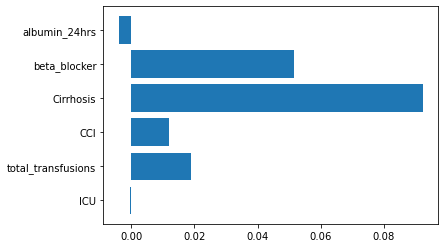

In [231]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

                    Importance
Cirrhosis             1.096842
beta_blocker          1.052749
total_transfusions    1.019255
CCI                   1.011953
ICU                   0.999742
albumin_24hrs         0.996006


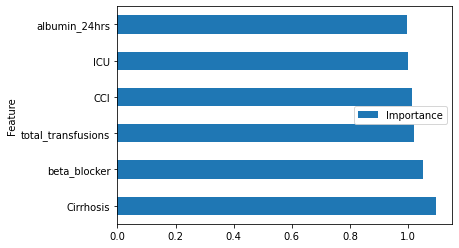

In [232]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [233]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [234]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[2853 2776]
 [2619 3010]]


In [235]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.52      0.51      0.51      5629
           1       0.52      0.53      0.53      5629

    accuracy                           0.52     11258
   macro avg       0.52      0.52      0.52     11258
weighted avg       0.52      0.52      0.52     11258



In [236]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[689 708]
 [307 374]]


In [237]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.69      0.49      0.58      1397
           1       0.35      0.55      0.42       681

    accuracy                           0.51      2078
   macro avg       0.52      0.52      0.50      2078
weighted avg       0.58      0.51      0.53      2078



## 1: Decision Tree (Max Depth=3)

In [302]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=3)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

Feature: ICU Score: 0.00000
Feature: mass_transfusion Score: 0.15564
Feature: total_transfusions Score: 0.00000
Feature: anemia_status Score: 0.40760
Feature: CCI Score: 0.00000
Feature: bl_albumin_value Score: 0.04301
Feature: qSOFA Score: 0.35226
Feature: Cirrhosis Score: 0.00000
Feature: beta_blocker Score: 0.00000
Feature: hemorrhagic Score: 0.00000
Feature: SAPS Score: 0.04150
Feature: albumin_24hrs Score: 0.00000


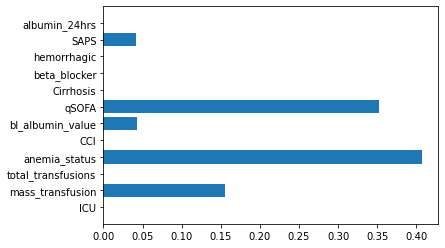

In [303]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [304]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [305]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[2509 3118]
 [1524 4103]]


In [306]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.62      0.45      0.52      5627
           1       0.57      0.73      0.64      5627

    accuracy                           0.59     11254
   macro avg       0.60      0.59      0.58     11254
weighted avg       0.60      0.59      0.58     11254



In [307]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[602 797]
 [239 440]]


In [308]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.72      0.43      0.54      1399
           1       0.36      0.65      0.46       679

    accuracy                           0.50      2078
   macro avg       0.54      0.54      0.50      2078
weighted avg       0.60      0.50      0.51      2078



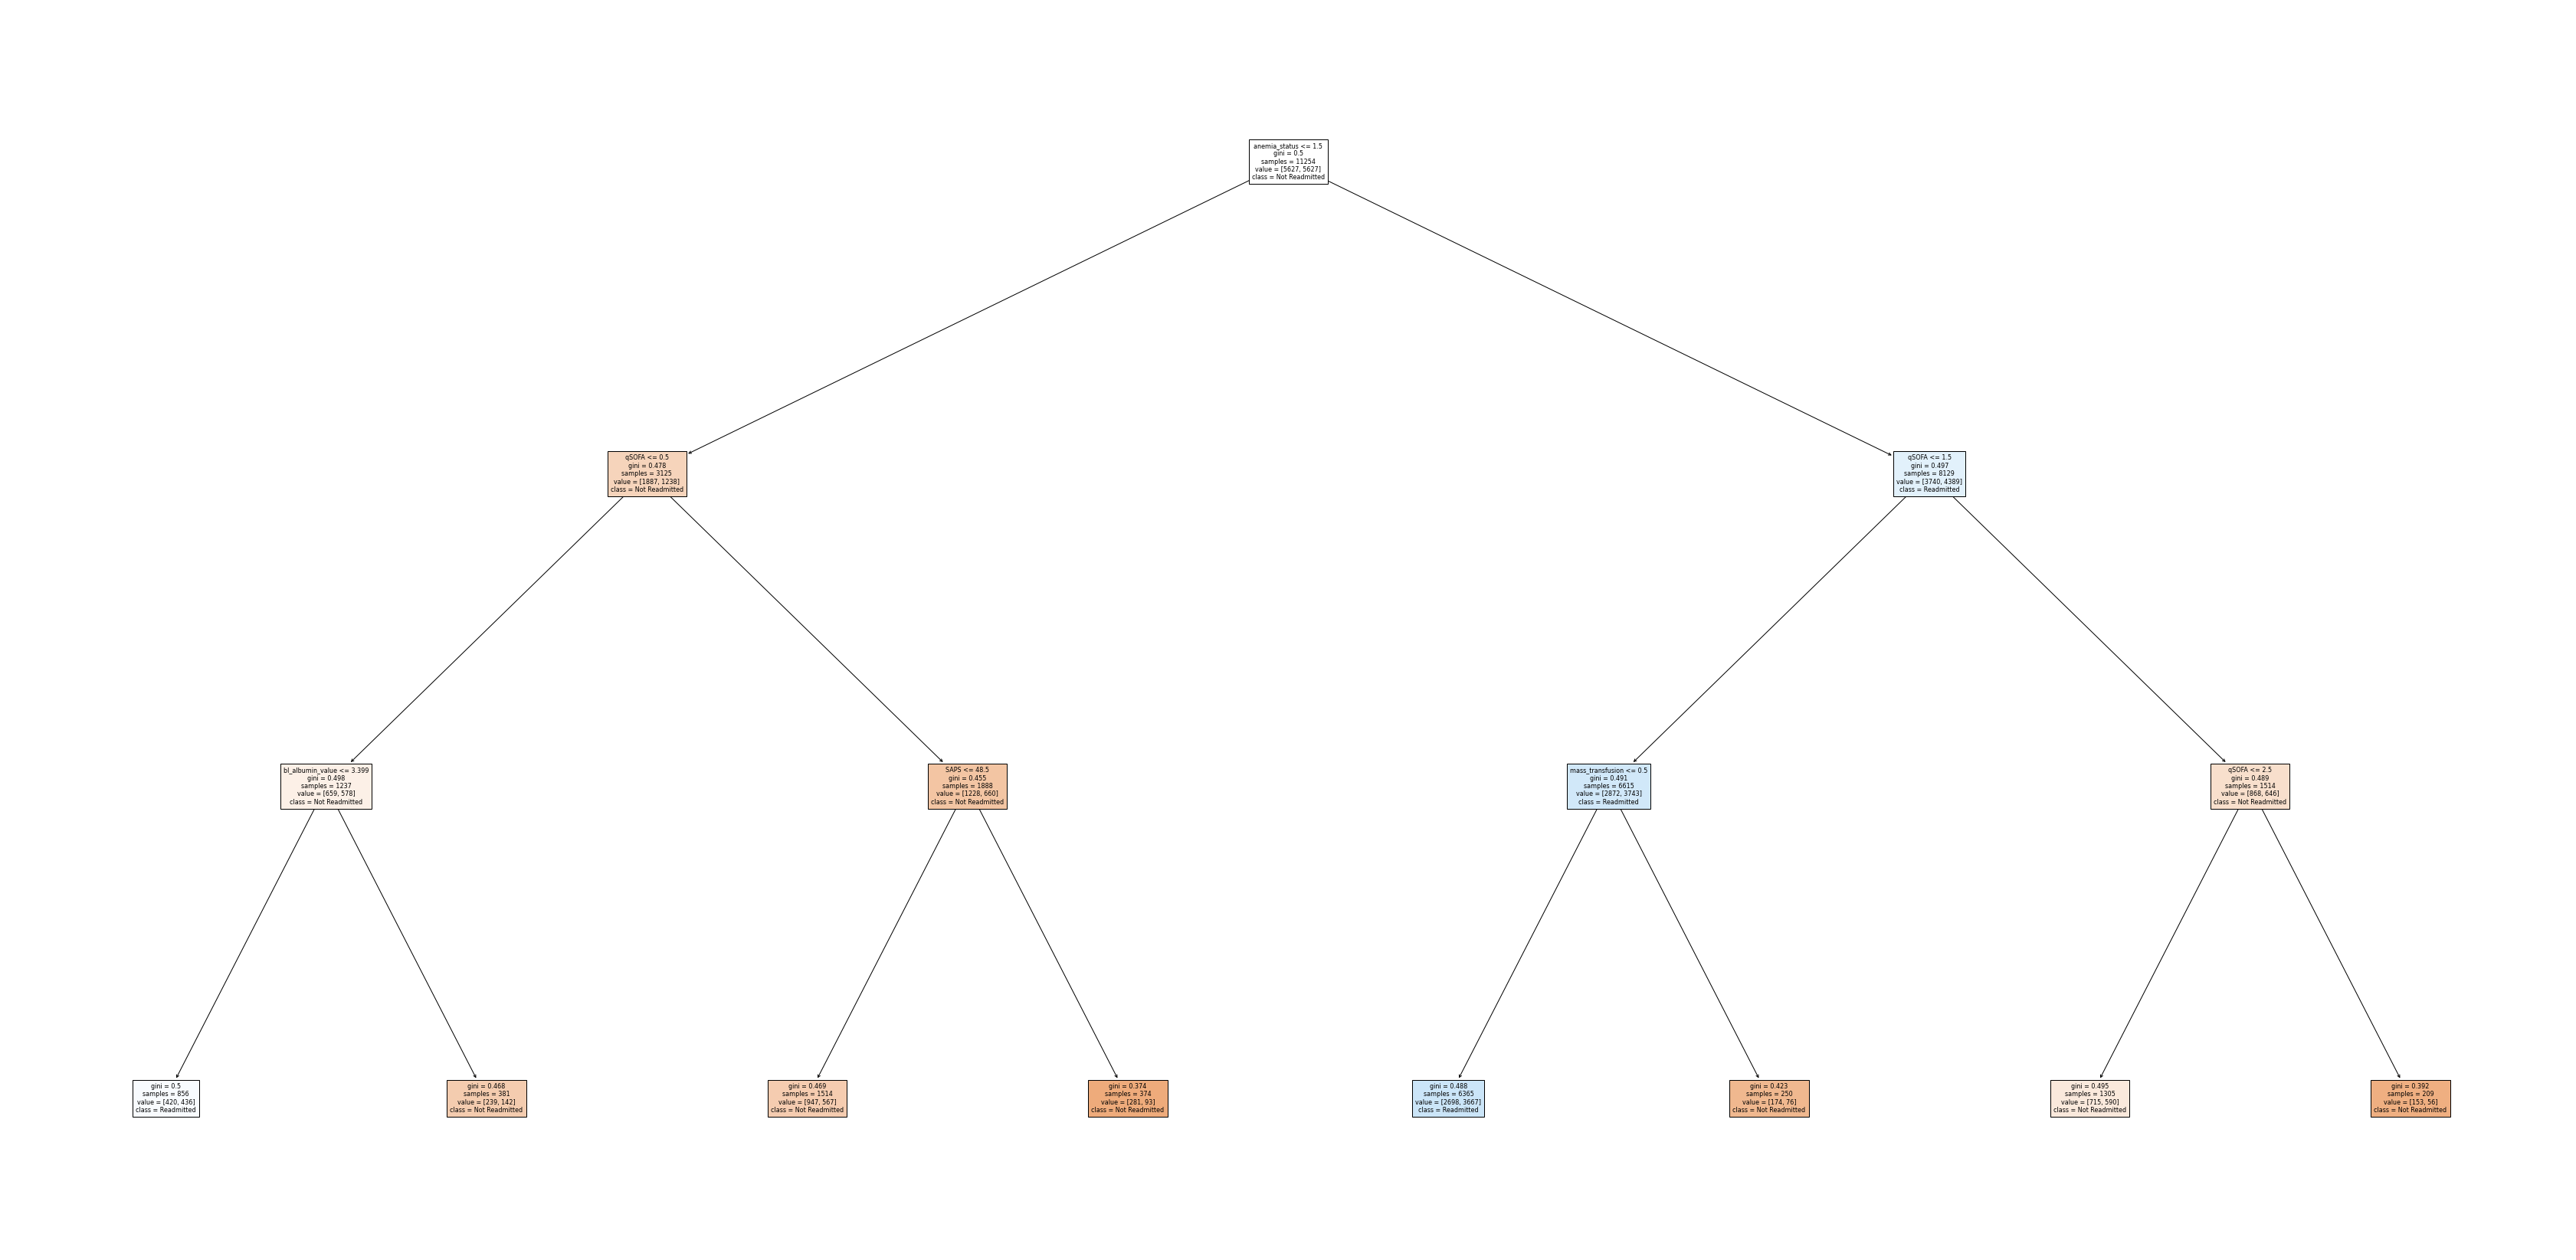

In [309]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [246]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.write_png('30DRA_DT_D3_NCBL.png')

True

## 2: Decision Tree (Max Depth=4)

In [310]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=4)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

Feature: ICU Score: 0.00000
Feature: mass_transfusion Score: 0.12502
Feature: total_transfusions Score: 0.01444
Feature: anemia_status Score: 0.32743
Feature: CCI Score: 0.01907
Feature: bl_albumin_value Score: 0.11488
Feature: qSOFA Score: 0.28297
Feature: Cirrhosis Score: 0.00000
Feature: beta_blocker Score: 0.00000
Feature: hemorrhagic Score: 0.07392
Feature: SAPS Score: 0.04226
Feature: albumin_24hrs Score: 0.00000


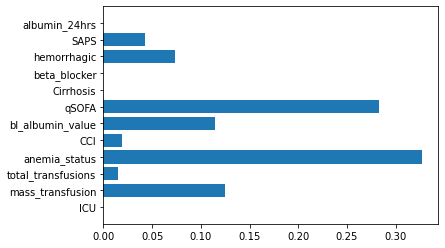

In [311]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [312]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [313]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[2904 2723]
 [1860 3767]]


In [314]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.61      0.52      0.56      5627
           1       0.58      0.67      0.62      5627

    accuracy                           0.59     11254
   macro avg       0.60      0.59      0.59     11254
weighted avg       0.60      0.59      0.59     11254



In [315]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[711 688]
 [287 392]]


In [316]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.71      0.51      0.59      1399
           1       0.36      0.58      0.45       679

    accuracy                           0.53      2078
   macro avg       0.54      0.54      0.52      2078
weighted avg       0.60      0.53      0.55      2078



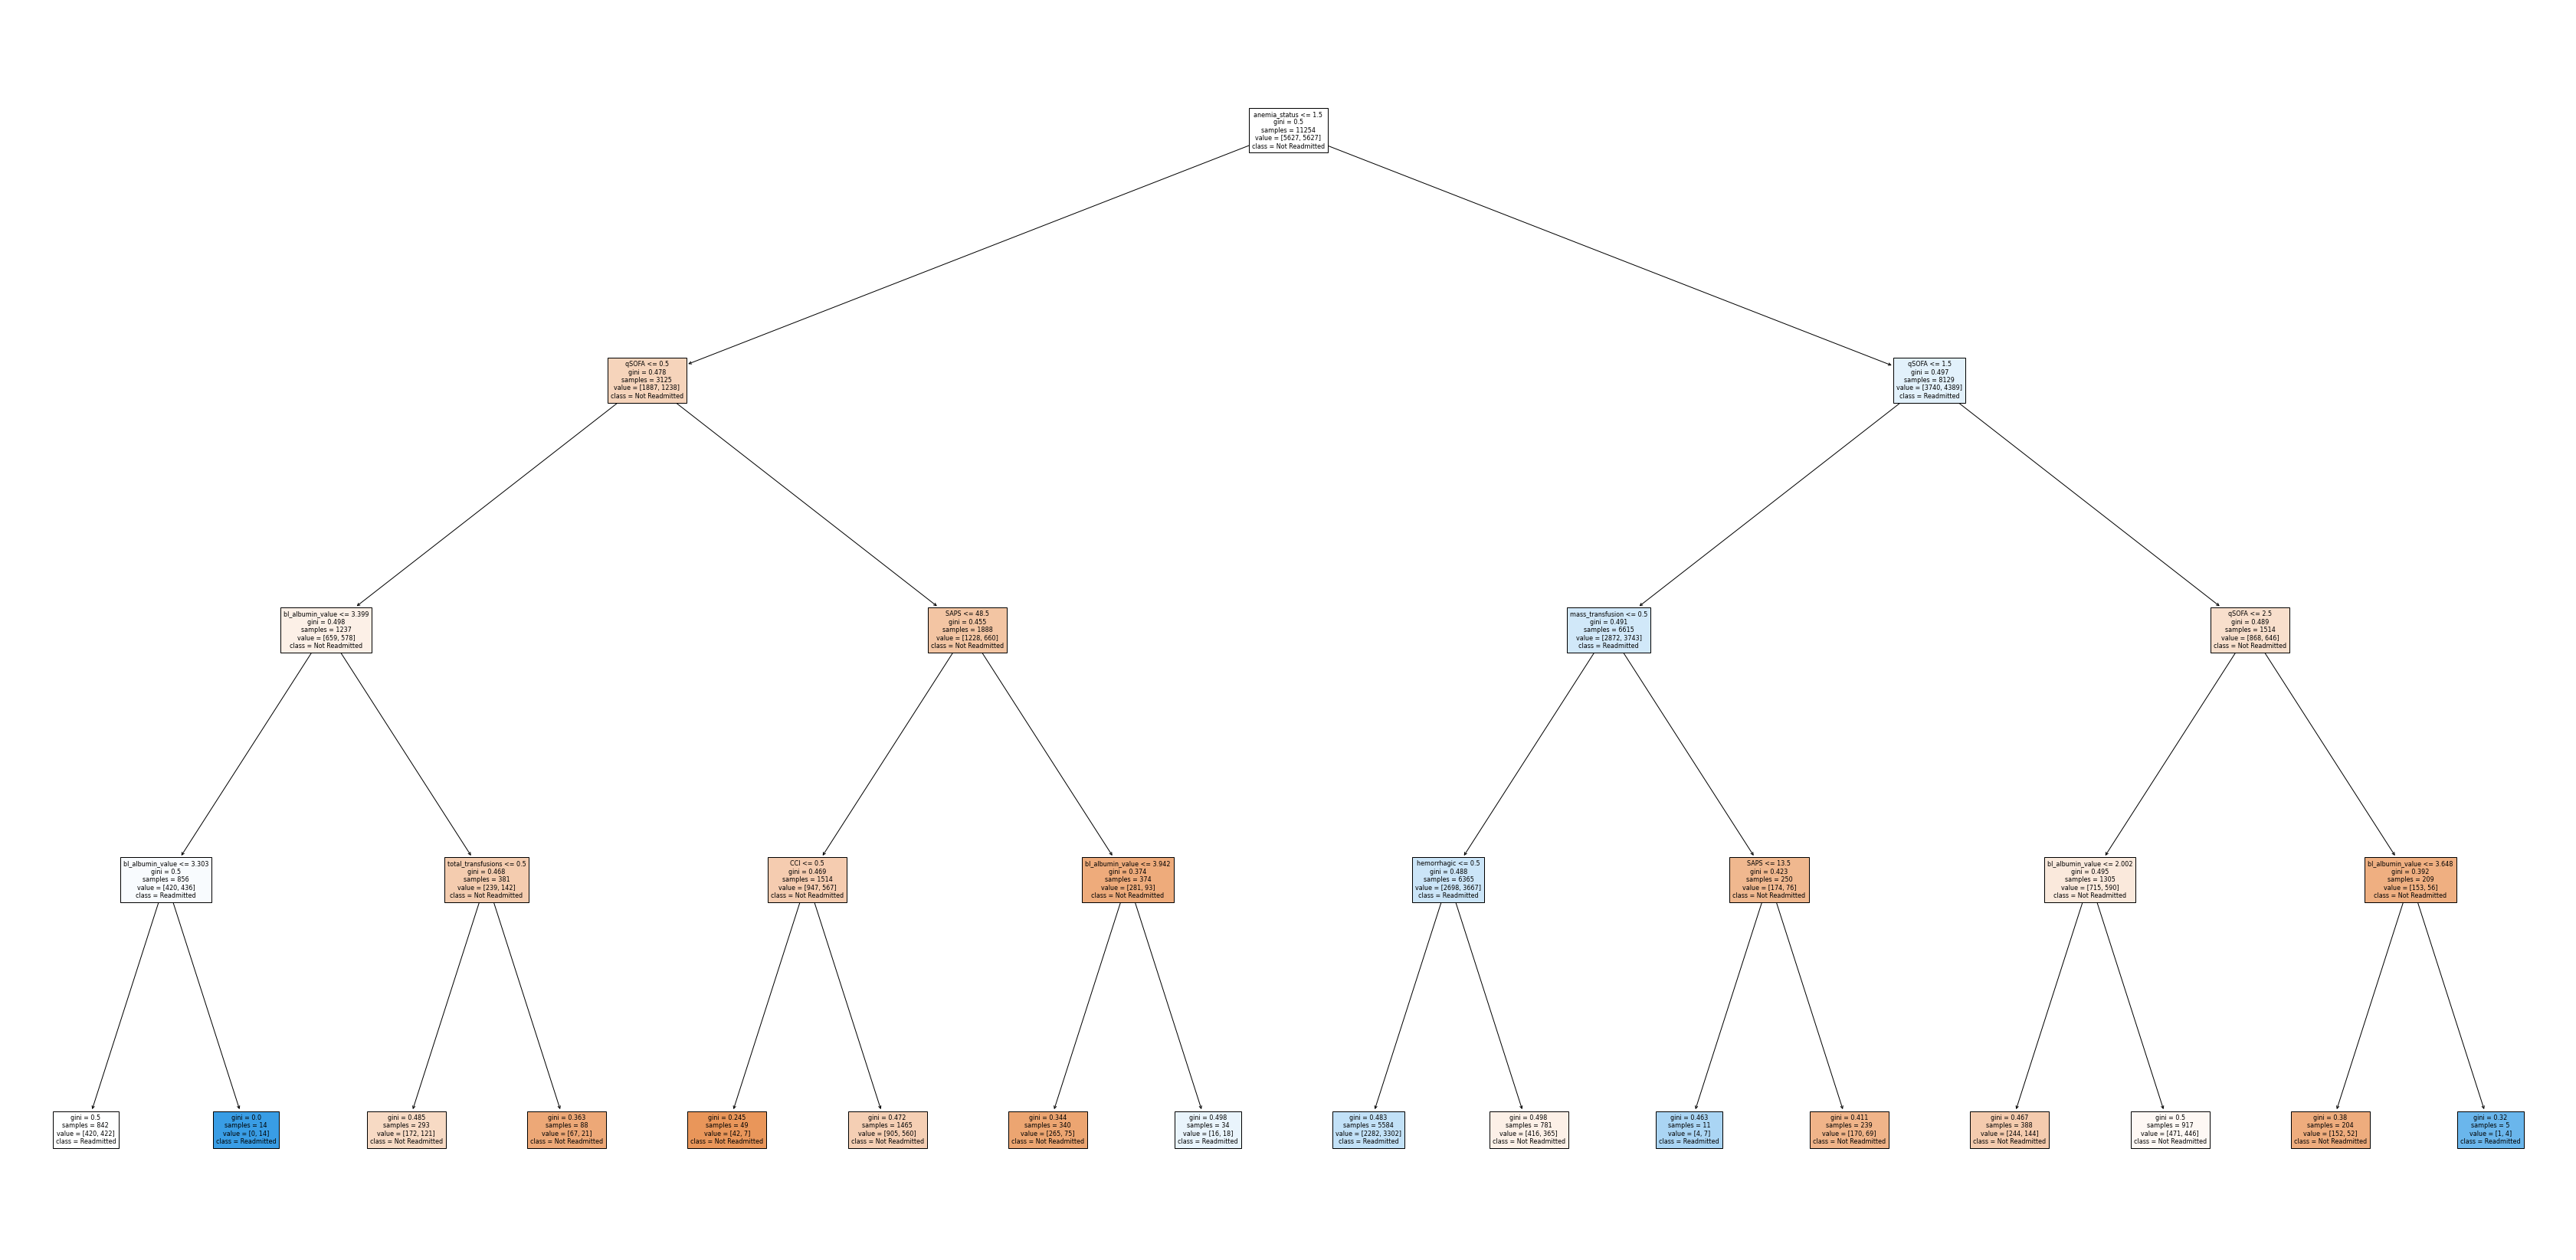

In [317]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [42]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.write_png('30DRA_DT_D4_NCBL.png')

True

## 3: Decision Tree 

In [318]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)

Feature: ICU Score: 0.00897
Feature: mass_transfusion Score: 0.11108
Feature: total_transfusions Score: 0.00000
Feature: anemia_status Score: 0.29090
Feature: CCI Score: 0.02077
Feature: bl_albumin_value Score: 0.08010
Feature: qSOFA Score: 0.26924
Feature: Cirrhosis Score: 0.00796
Feature: beta_blocker Score: 0.00801
Feature: hemorrhagic Score: 0.06568
Feature: SAPS Score: 0.12672
Feature: albumin_24hrs Score: 0.01056


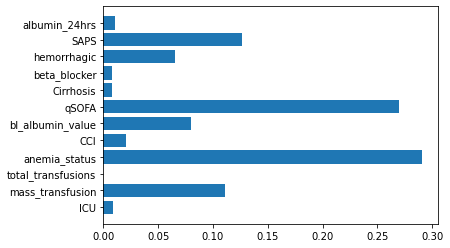

In [319]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [320]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [321]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3538 2089]
 [2406 3221]]


In [322]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.60      0.63      0.61      5627
           1       0.61      0.57      0.59      5627

    accuracy                           0.60     11254
   macro avg       0.60      0.60      0.60     11254
weighted avg       0.60      0.60      0.60     11254



In [323]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[864 535]
 [359 320]]


In [324]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.71      0.62      0.66      1399
           1       0.37      0.47      0.42       679

    accuracy                           0.57      2078
   macro avg       0.54      0.54      0.54      2078
weighted avg       0.60      0.57      0.58      2078



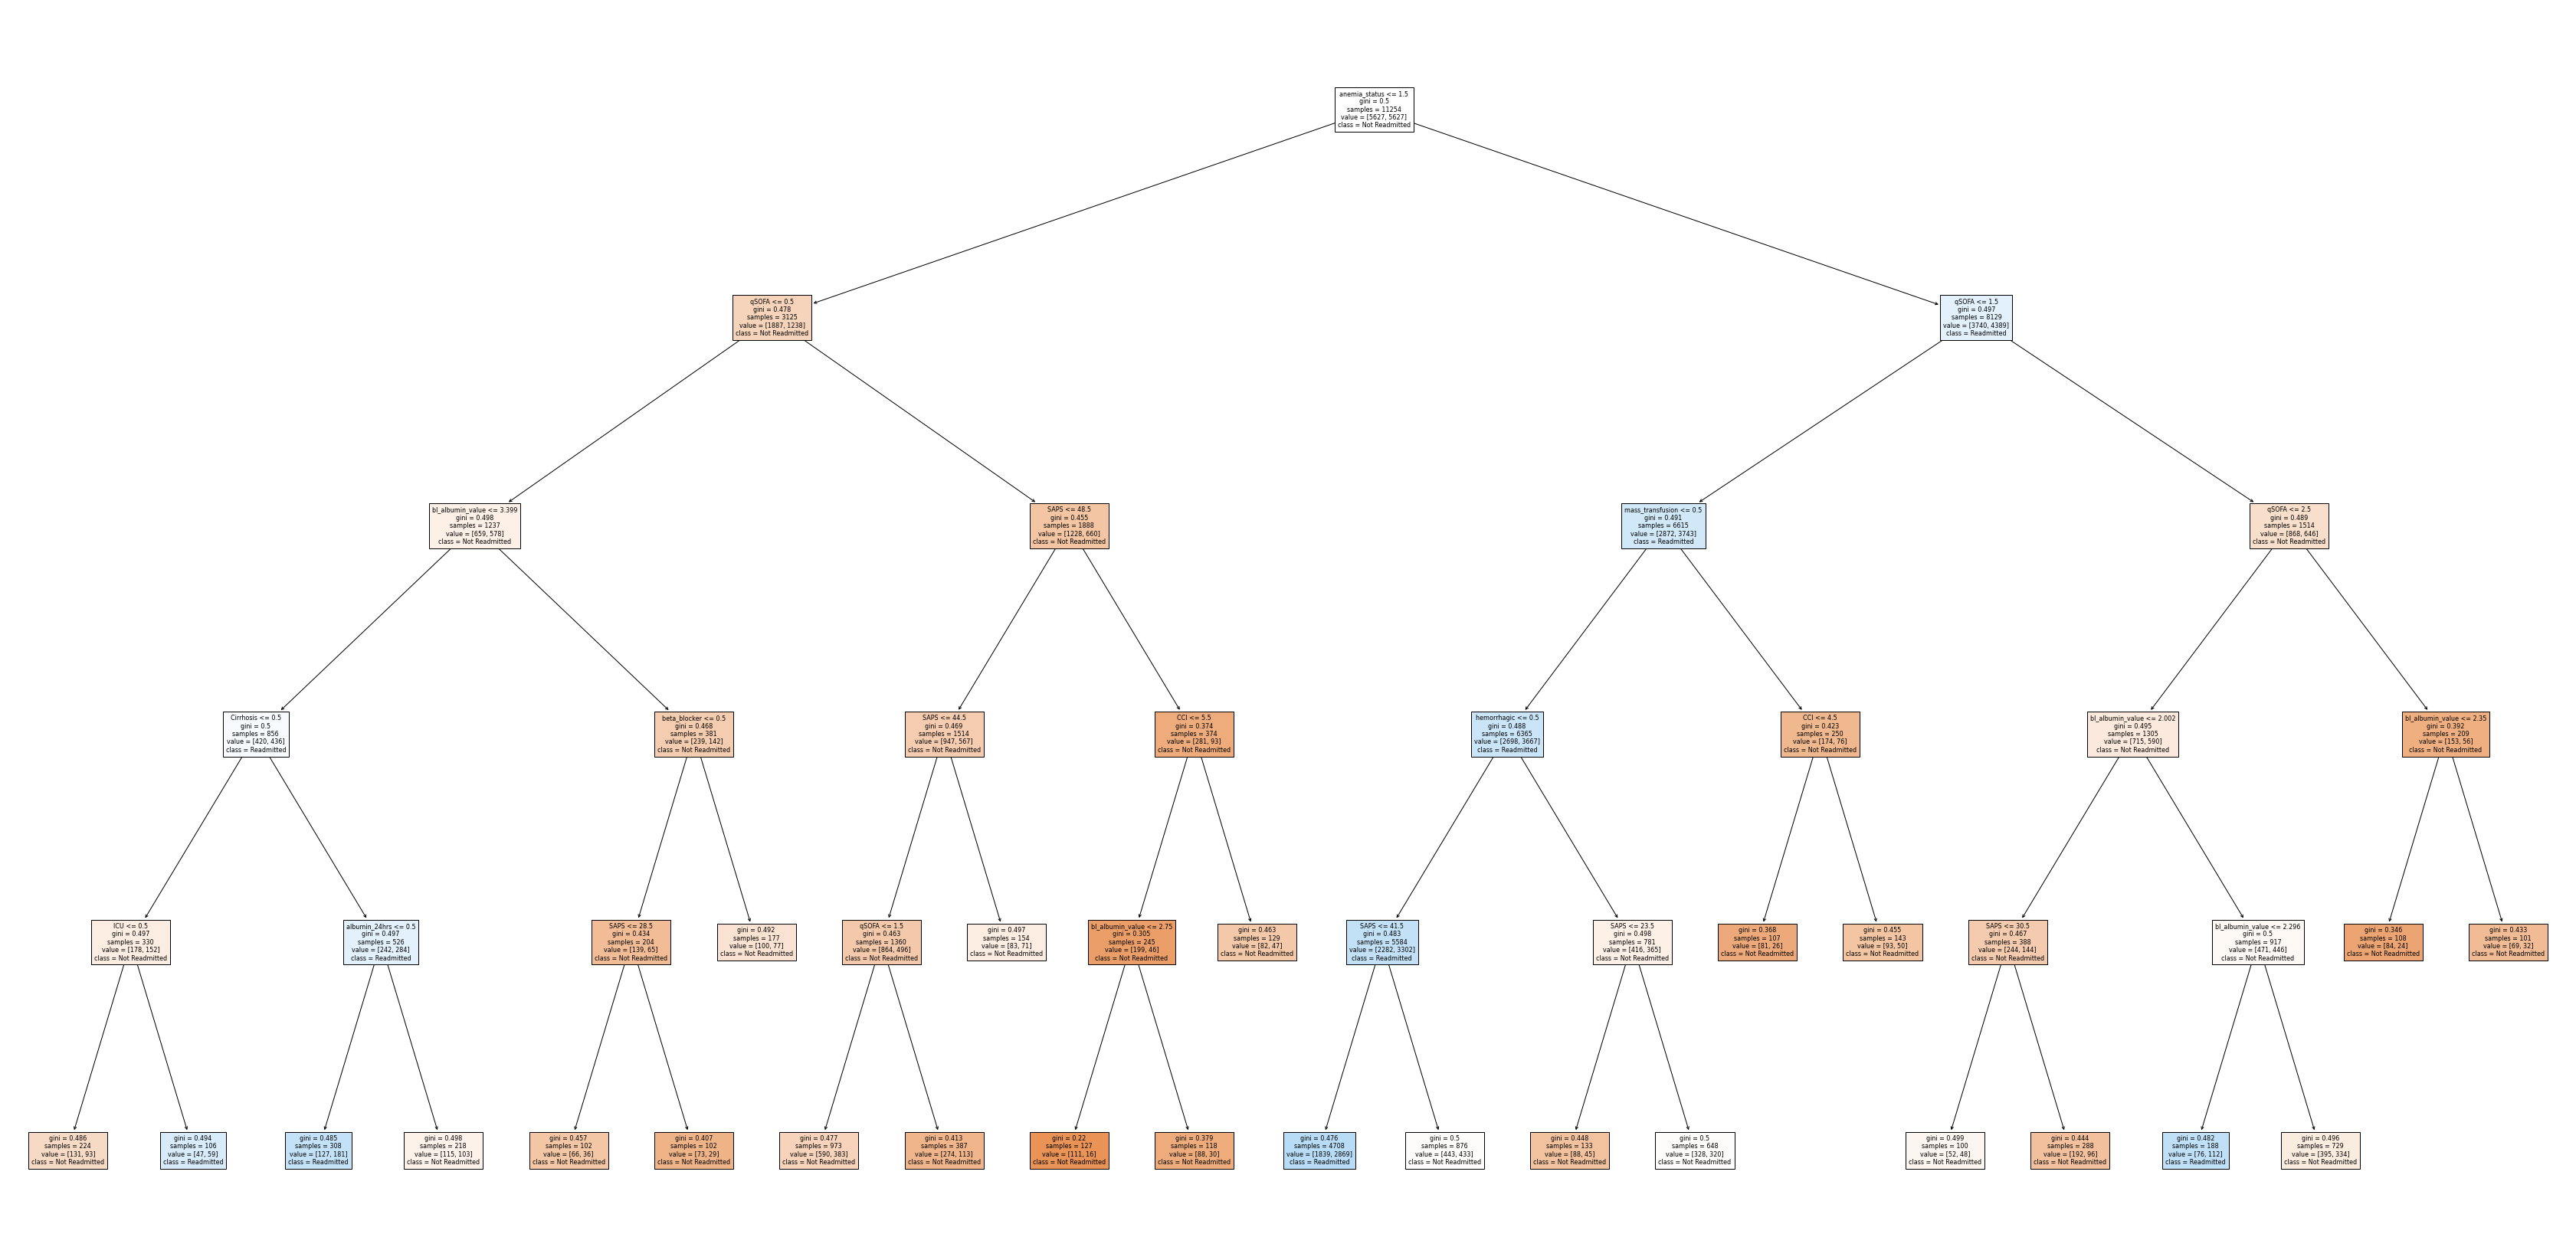

In [325]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [51]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DRA_DT_D5_NCBL.png')

True

## 4: Decision Tree 

In [326]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)

Feature: ICU Score: 0.03566
Feature: mass_transfusion Score: 0.09760
Feature: total_transfusions Score: 0.00653
Feature: anemia_status Score: 0.25898
Feature: CCI Score: 0.03170
Feature: bl_albumin_value Score: 0.12049
Feature: qSOFA Score: 0.23657
Feature: Cirrhosis Score: 0.00699
Feature: beta_blocker Score: 0.00704
Feature: hemorrhagic Score: 0.06582
Feature: SAPS Score: 0.11721
Feature: albumin_24hrs Score: 0.01541


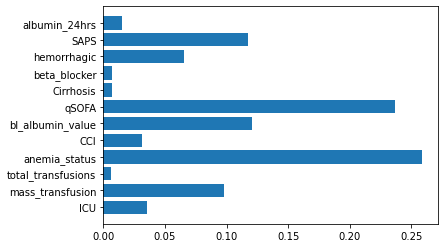

In [327]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [328]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [329]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3144 2483]
 [1918 3709]]


In [330]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.62      0.56      0.59      5627
           1       0.60      0.66      0.63      5627

    accuracy                           0.61     11254
   macro avg       0.61      0.61      0.61     11254
weighted avg       0.61      0.61      0.61     11254



In [331]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[745 654]
 [310 369]]


In [332]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.71      0.53      0.61      1399
           1       0.36      0.54      0.43       679

    accuracy                           0.54      2078
   macro avg       0.53      0.54      0.52      2078
weighted avg       0.59      0.54      0.55      2078



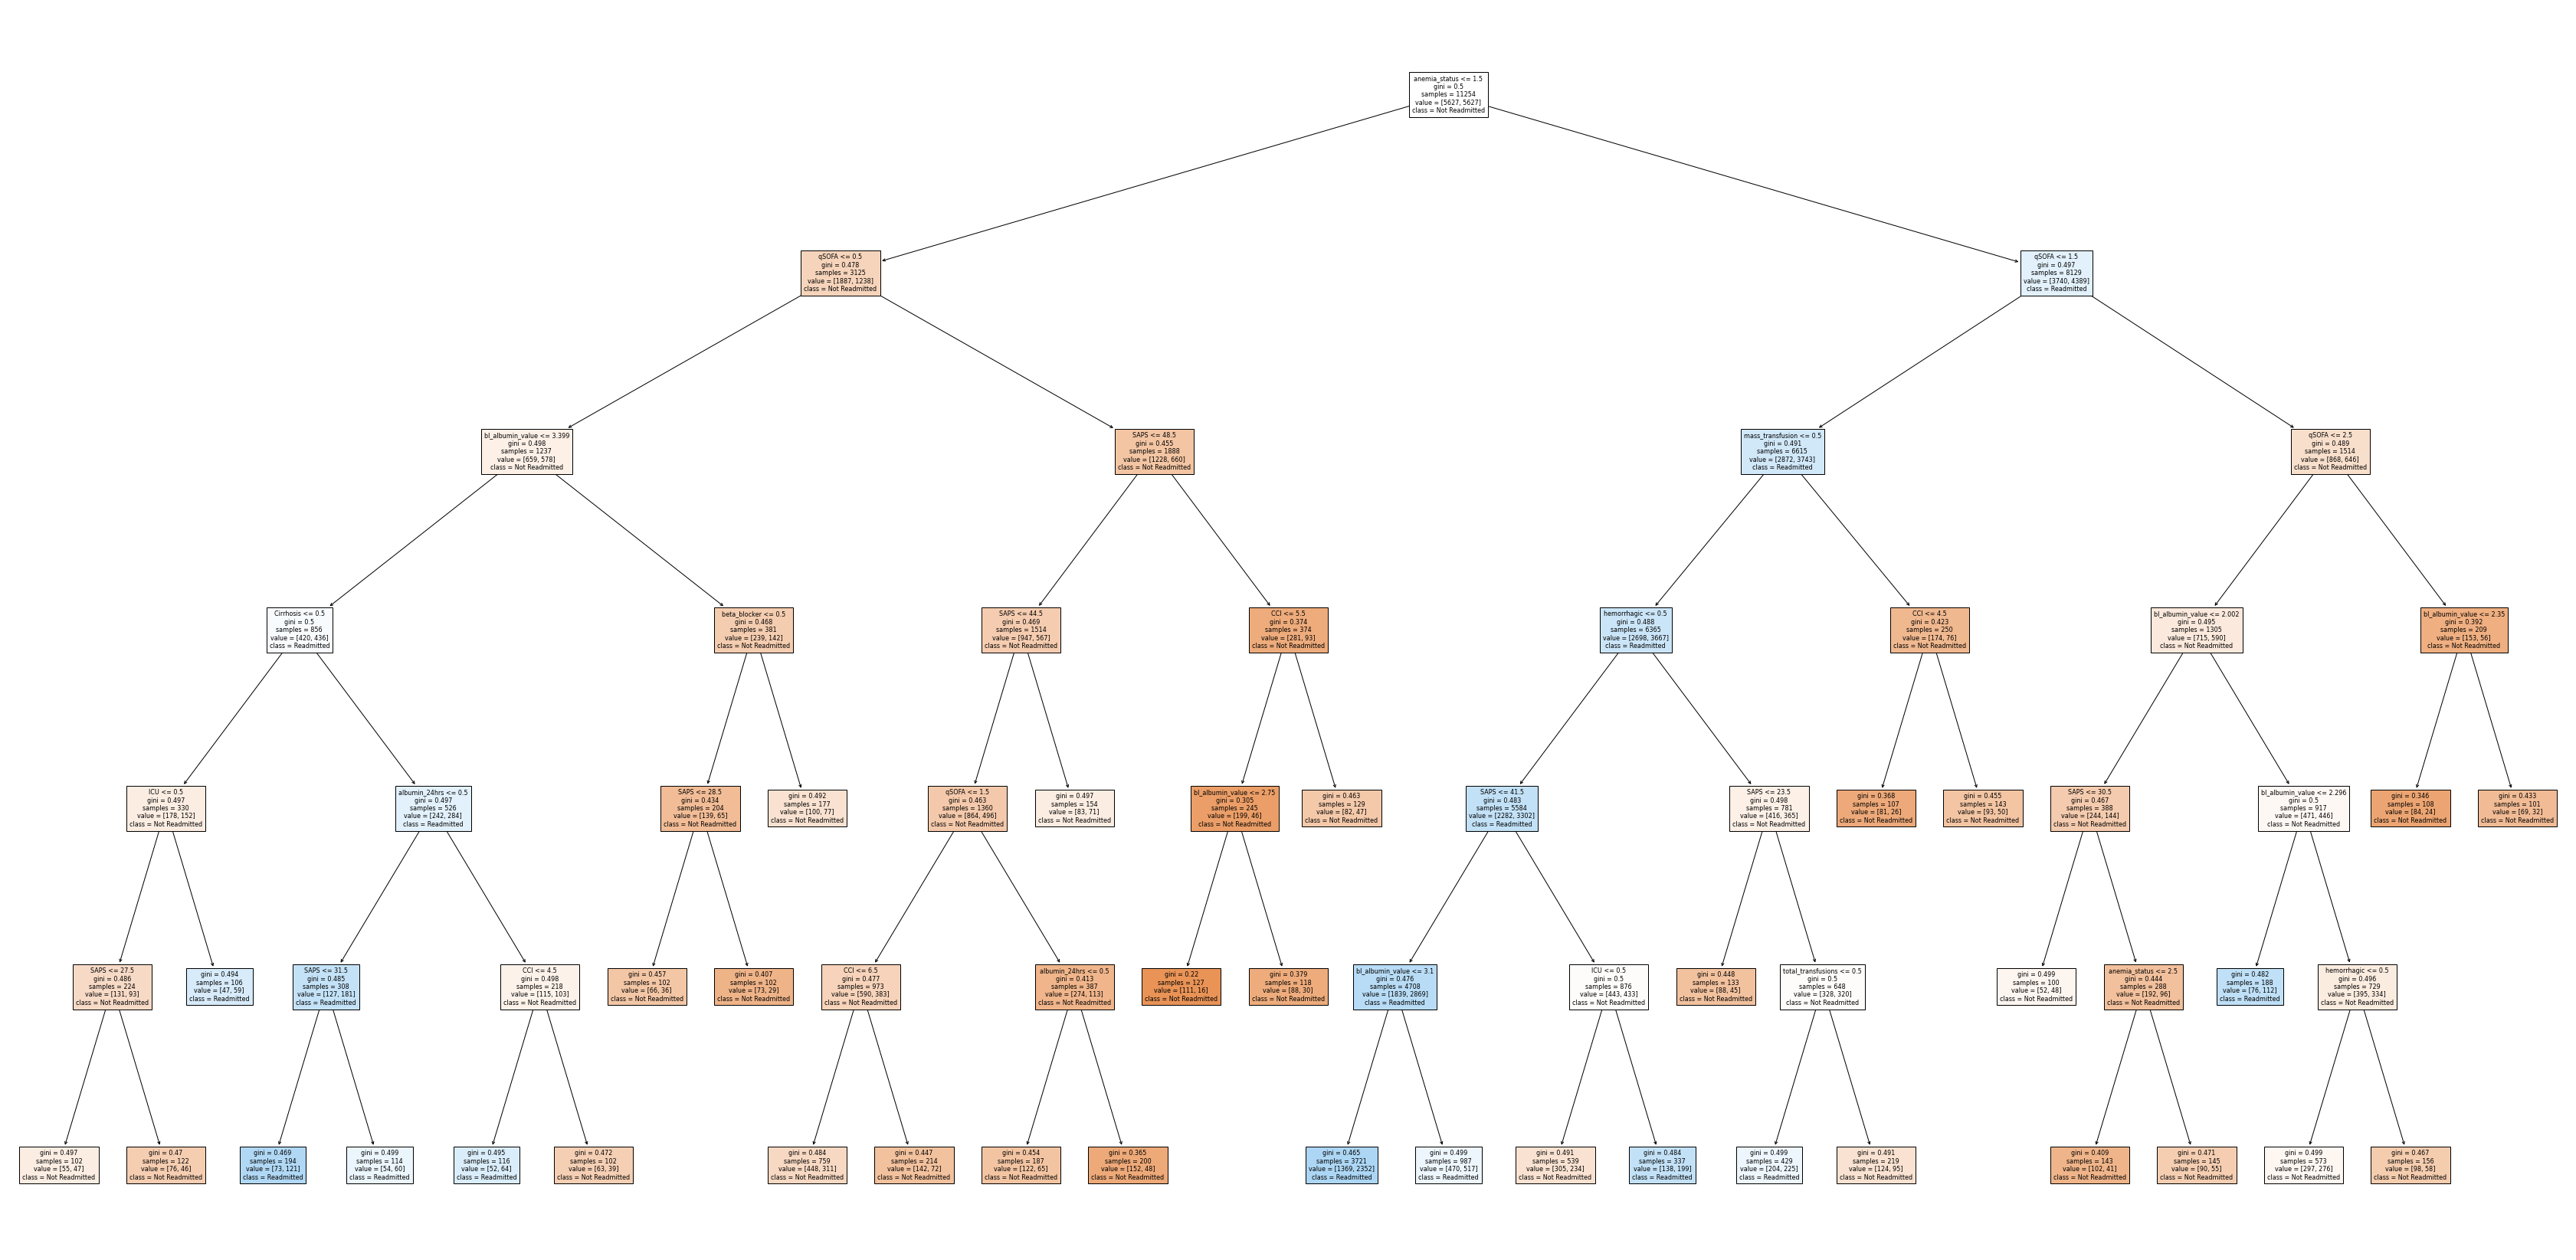

In [333]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [60]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DRA_DT_D6_NCBL.png')

True

## 5: Decision Tree 

In [334]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.03086
Feature: mass_transfusion Score: 0.08446
Feature: total_transfusions Score: 0.00565
Feature: anemia_status Score: 0.23640
Feature: CCI Score: 0.02743
Feature: bl_albumin_value Score: 0.16208
Feature: qSOFA Score: 0.20472
Feature: Cirrhosis Score: 0.01303
Feature: beta_blocker Score: 0.02058
Feature: hemorrhagic Score: 0.05696
Feature: SAPS Score: 0.11751
Feature: albumin_24hrs Score: 0.04031


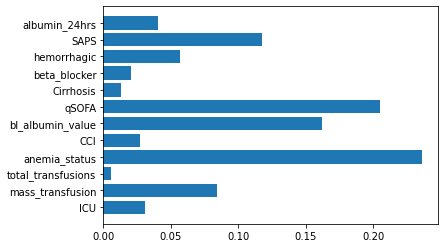

In [335]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [336]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [337]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3552 2075]
 [2210 3417]]


In [338]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.62      0.63      0.62      5627
           1       0.62      0.61      0.61      5627

    accuracy                           0.62     11254
   macro avg       0.62      0.62      0.62     11254
weighted avg       0.62      0.62      0.62     11254



In [339]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[849 550]
 [372 307]]


In [340]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.70      0.61      0.65      1399
           1       0.36      0.45      0.40       679

    accuracy                           0.56      2078
   macro avg       0.53      0.53      0.52      2078
weighted avg       0.59      0.56      0.57      2078



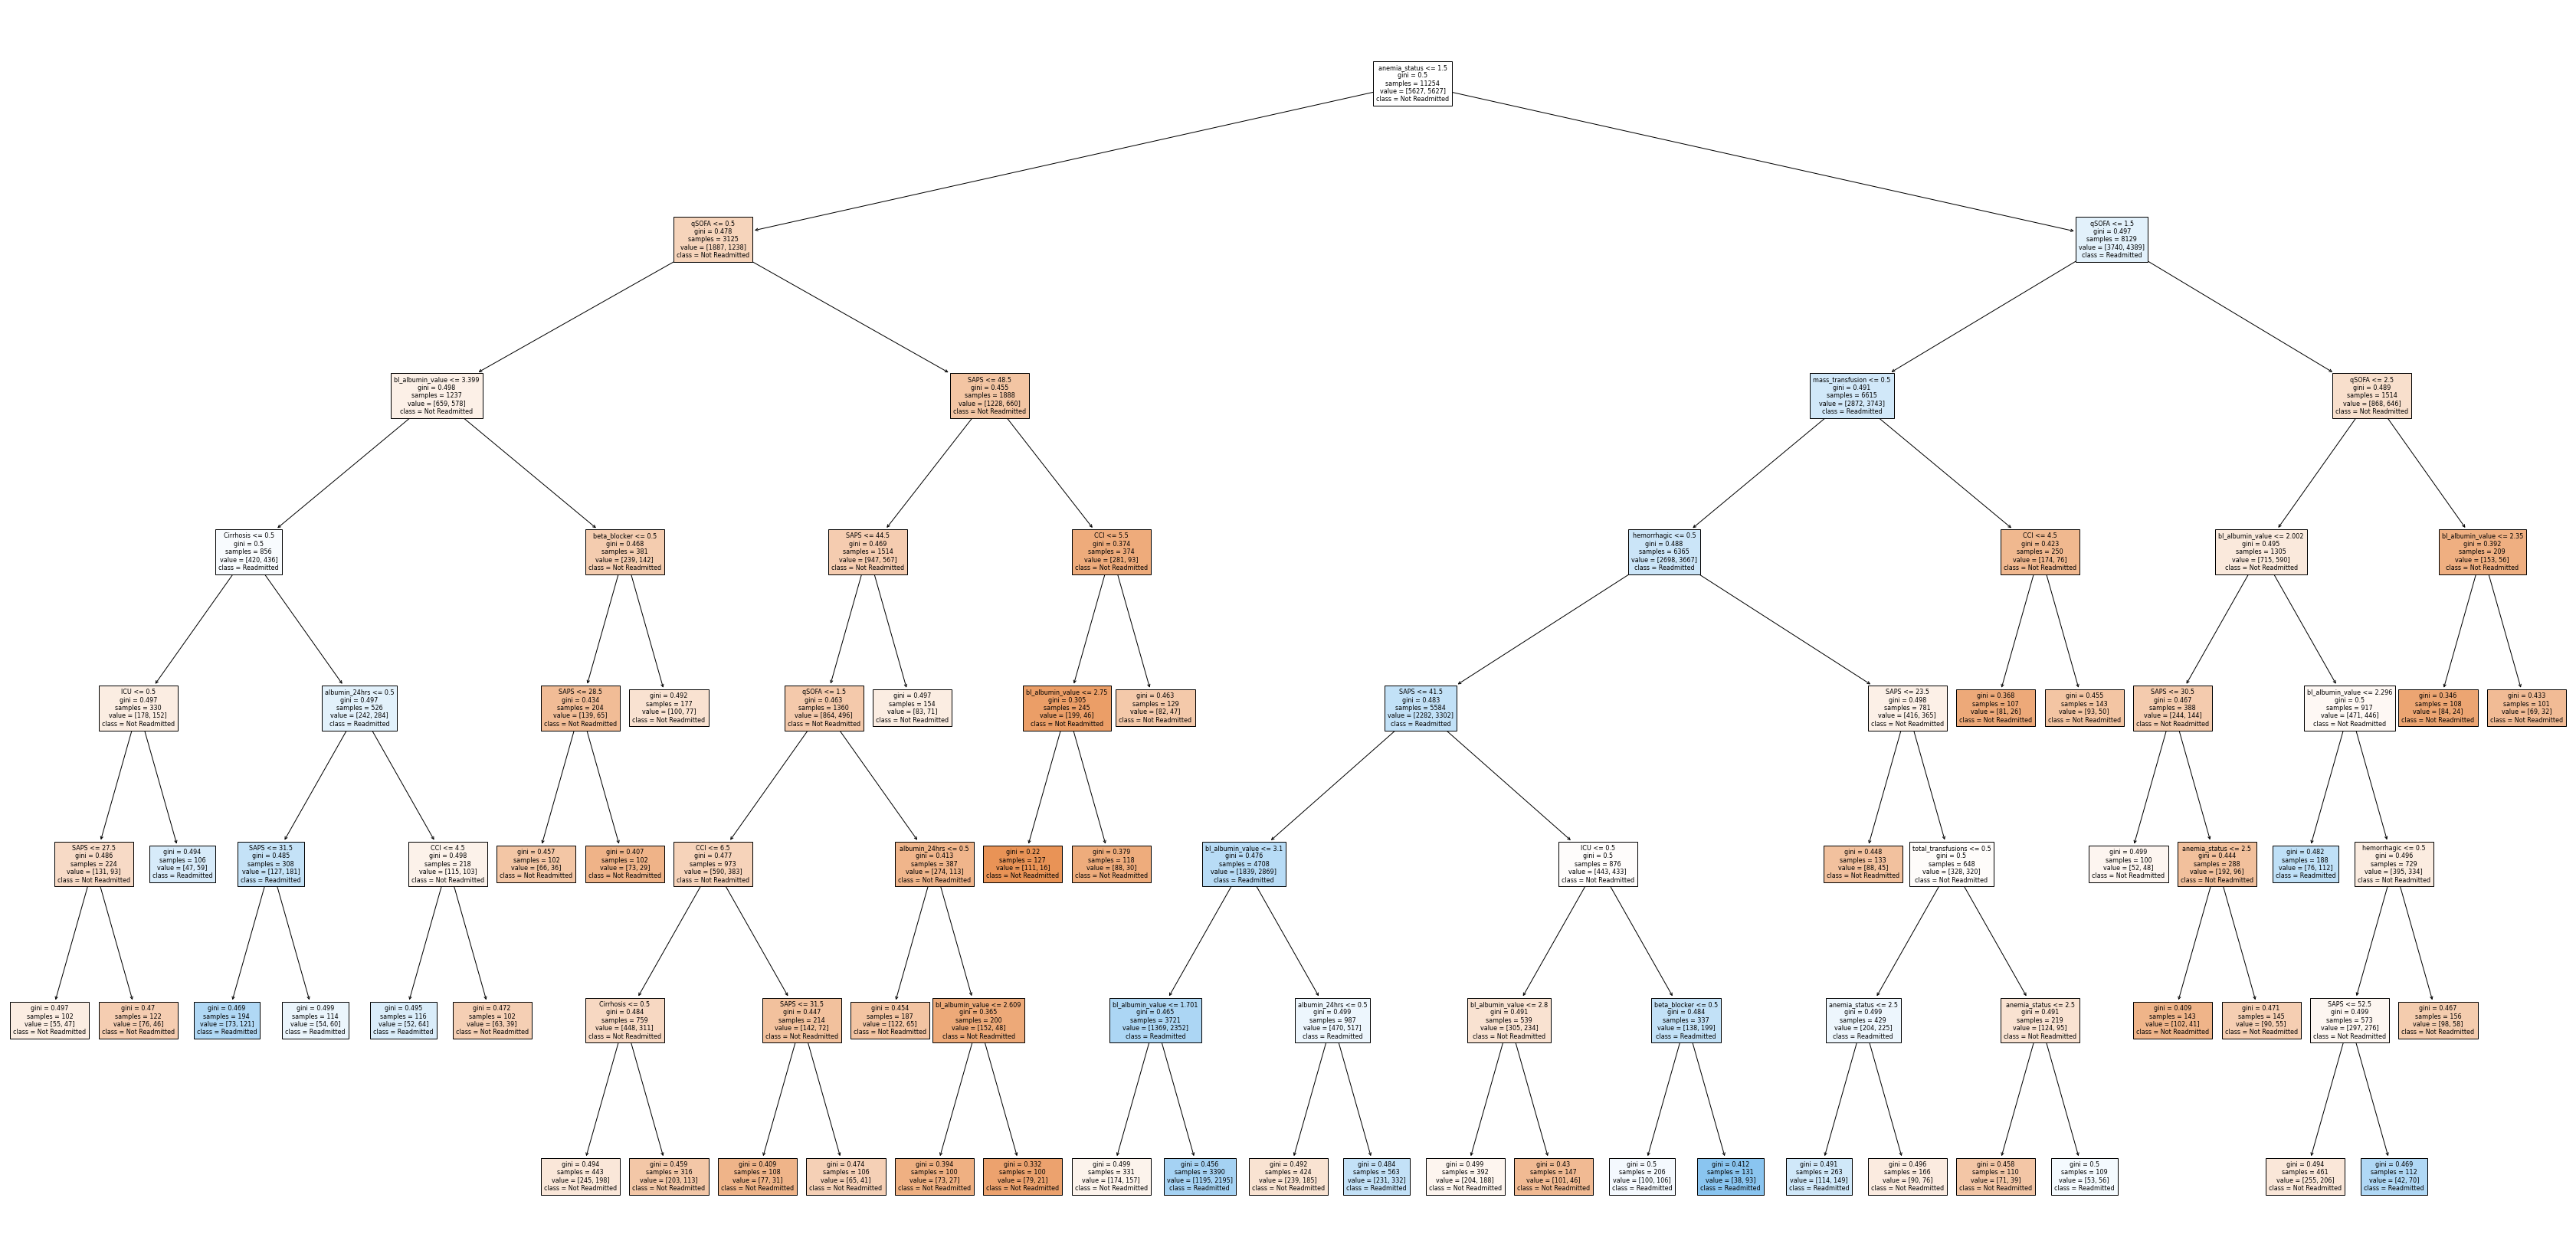

In [341]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [69]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.write_png('30DRA_DT_D7_NCBL.png')

True

## 6: Decision Tree 

In [342]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=100)

Feature: ICU Score: 0.02855
Feature: mass_transfusion Score: 0.07814
Feature: total_transfusions Score: 0.00523
Feature: anemia_status Score: 0.23457
Feature: CCI Score: 0.03377
Feature: bl_albumin_value Score: 0.16639
Feature: qSOFA Score: 0.18940
Feature: Cirrhosis Score: 0.02734
Feature: beta_blocker Score: 0.02585
Feature: hemorrhagic Score: 0.05270
Feature: SAPS Score: 0.12075
Feature: albumin_24hrs Score: 0.03730


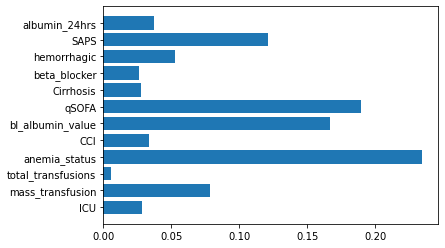

In [343]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [344]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [345]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3432 2195]
 [2032 3595]]


In [346]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.63      0.61      0.62      5627
           1       0.62      0.64      0.63      5627

    accuracy                           0.62     11254
   macro avg       0.62      0.62      0.62     11254
weighted avg       0.62      0.62      0.62     11254



In [347]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[823 576]
 [347 332]]


In [348]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.70      0.59      0.64      1399
           1       0.37      0.49      0.42       679

    accuracy                           0.56      2078
   macro avg       0.53      0.54      0.53      2078
weighted avg       0.59      0.56      0.57      2078



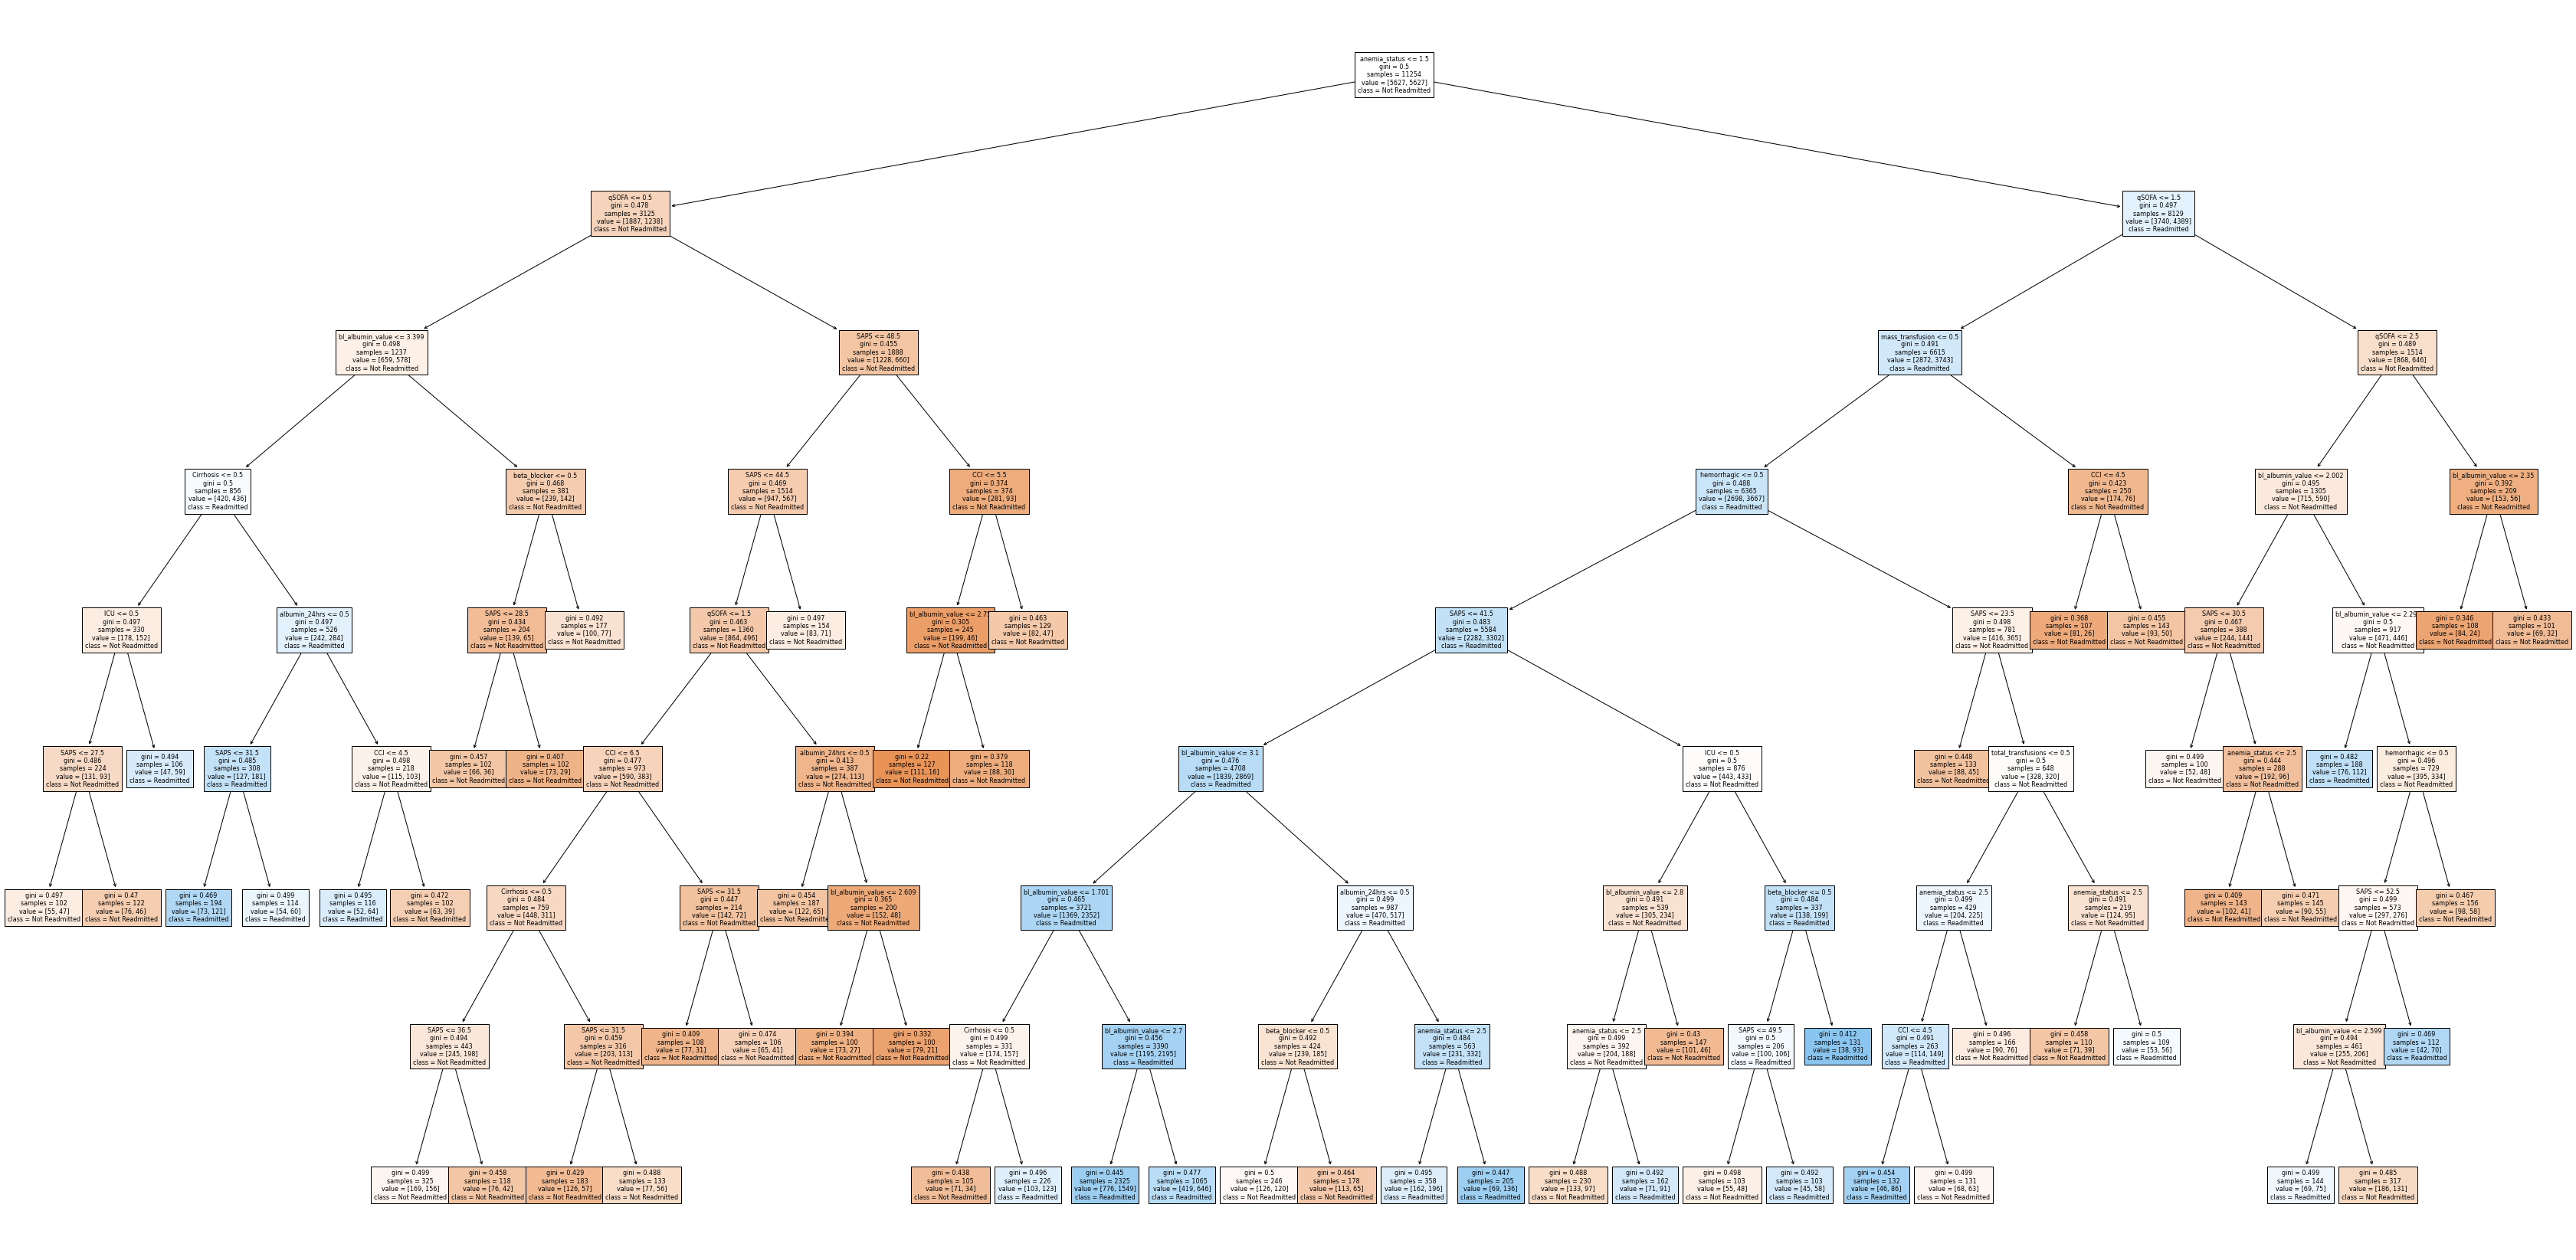

In [349]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [351]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DRA_DT_D8_NCBL_MATCHED.png')

True

## Random Forest

In [79]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [80]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [81]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[19668 14674]
 [14540 19802]]


In [82]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57     34342
           1       0.57      0.58      0.58     34342

    accuracy                           0.57     68684
   macro avg       0.57      0.57      0.57     68684
weighted avg       0.57      0.57      0.57     68684



In [83]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4861 3649]
 [1780 1932]]


In [84]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64      8510
           1       0.35      0.52      0.42      3712

    accuracy                           0.56     12222
   macro avg       0.54      0.55      0.53     12222
weighted avg       0.61      0.56      0.57     12222



Feature: anemia_status Score: 0.12464
Feature: CCI Score: 0.40683
Feature: albumin_24hrs Score: 0.04143
Feature: qSOFA Score: 0.05016
Feature: SAPS Score: 0.37694


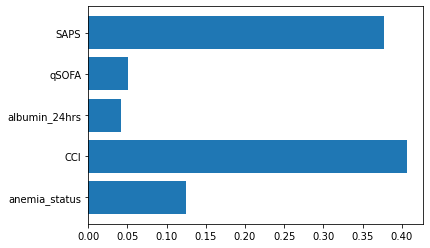

In [85]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()